# Image Captioning with LSTMs

In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

## 1. Basic settings

In [1]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from CS231n.RNN_layers import *
from CS231n.Captioning_solver import CaptioningSolver
from CS231n.classifiers.rnn import CaptioningRNN
from CS231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from CS231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 2. Microsoft COCO

For this exercise we will use the 2014 release of the Microsoft COCO dataset which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images.

- *train2014_vgg16_fc7.h5 and val2014_vgg16_fc7.h5*: features extracted from the fc7 layer of the VGG-16 network pretrained on ImageNet.
- *train2014_vgg16_fc7_pca.h5 and val2014_vgg16_fc7_pca.h5*:  reduced the dimensionality of the features from 4096 to 512 using PCA.
- *train2014_urls.txt and val2014_urls.txt*: URLs of the training and validation images.
- *coco2014_vocab.json*: Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in this file. you can use the function **decode_captions** from the file CS231n/coco_utils.py to convert numpy arrays of integer IDs back into strings.

**Note**

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [3]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## 3 Understanding LSTM
Reference: [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### 3.1 LSTM Networks
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width = "600" height = "600" alt="LSTM3-SimpleRNN" align=center />

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width = "600" height = "600" alt="LSTM3-chain" align=center />

Don’t worry about the details of what’s going on. We’ll walk through the LSTM diagram step by step later. For now, let’s just try to get comfortable with the notation we’ll be using.
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width = "600" height = "600" alt="LSTM2-notation" align=center />
In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. The pink circles represent pointwise operations, like vector addition, while the yellow boxes are learned neural network layers. Lines merging denote concatenation, while a line forking denote its content being copied and the copies going to different locations.

### 3.2 The Core Idea Behind LSTMs

The key to LSTMs is the cell state, the horizontal line running through the top of the diagram.

The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png" width = "800" height = "800" alt="LSTM3-C-line" align=center />

The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.

Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-gate.png" width = "100" height = "100" alt="LSTM3-C-line" align=center />
The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

An LSTM has three of these gates, to protect and control the cell state.
### 3.3 Step-by-Step LSTM Walk Through

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at $h_{t−1}$ and $x_t$, and outputs a number between **0** and **1** for each number in the cell state $C_{t−1}$. A **1** represents “completely keep this” while a 00 represents “completely get rid of this.”

Let’s go back to our example of a language model trying to predict the next word based on all the previous ones. In such a problem, the cell state might include the gender of the present subject, so that the correct pronouns can be used. When we see a new subject, we want to forget the gender of the old subject.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png" width = "800" height = "800" alt="LSTM3-C-line" align=center />

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, ${\tilde C_t}$, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

In the example of our language model, we’d want to add the gender of the new subject to the cell state, to replace the old one we’re forgetting.

http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png

### 3.3 Step-by-Step LSTM Walk Through

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at $h_{t−1}$ and $x_t$, and outputs a number between **0** and **1** for each number in the cell state $C_{t−1}$. A **1** represents “completely keep this” while a 00 represents “completely get rid of this.”

Let’s go back to our example of a language model trying to predict the next word based on all the previous ones. In such a problem, the cell state might include the gender of the present subject, so that the correct pronouns can be used. When we see a new subject, we want to forget the gender of the old subject.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png" width = "800" height = "800" alt="LSTM3-C-line" align=center />

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, ${\tilde C_t}$, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

In the example of our language model, we’d want to add the gender of the new subject to the cell state, to replace the old one we’re forgetting.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png" width = "800" height = "800" alt="LSTM3-C-line" align=center />

It’s now time to update the old cell state, $C_{t−1}$, into the new cell state $C_t$. The previous steps already decided what to do, we just need to actually do it.

We multiply the old state by ftft, forgetting the things we decided to forget earlier. Then we add $i_t\times \tilde C_t$. This is the new candidate values, scaled by how much we decided to update each state value.

In the case of the language model, this is where we’d actually drop the information about the old subject’s gender and add the new information, as we decided in the previous steps.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png" width = "800" height = "800" alt="LSTM3-C-line" align=center />

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through **tanh** (to push the values to be between **−1** and **1**) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

For the language model example, since it just saw a subject, it might want to output information relevant to a verb, in case that’s what is coming next. For example, it might output whether the subject is singular or plural, so that we know what form a verb should be conjugated into if that’s what follows next.

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png" width = "800" height = "800" alt="LSTM3-C-line" align=center />

### 3.4 Implementation
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

### 3.5 LSTM: step forward

```python
  H = prev_h.shape[1]

  a = x.dot(Wx) + prev_h.dot(Wh) + b # of shape (N, 4H)
  i = sigmoid(a[:, : H])
  f = sigmoid(a[:, H:2*H])
  o = sigmoid(a[:, 2*H:3*H])
  g = np.tanh(a[:, 3*H:])

  next_c = f*prev_c + i*g 
  next_h = o*np.tanh(next_c)
  cache = (x, prev_h, prev_c, Wx, Wh, i, f, o, g, next_h, next_c)
```

In [4]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.70541311858e-09
next_c error:  5.81431230888e-09


### 3.6 LSTM: step backward

```python
   dnext_c = dnext_c + o*(1-np.tanh(next_c)**2)*dnext_h
  di = dnext_c * g
  df = dnext_c*prev_c 
  do = dnext_h*np.tanh(next_c)
  dg = dnext_c*i 
  dprev_c = f * dnext_c
  da = np.hstack((i*(1-i)*di, f*(1-f)*df, o*(1-o)*do, (1-g**2)*dg))

  dx = da.dot(Wx.T)
  dprev_h = da.dot(Wh.T)
  dWx = x.T.dot(da)
  dWh = prev_h.T.dot(da)
  db = np.sum(da, axis = 0)
```

In [5]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: LSTM_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = LSTM_step_backward(dnext_h, dnext_c, cache)

print( 'dx error: ', rel_error(dx_num, dx))
print( 'dh error: ', rel_error(dh_num, dh))
print( 'dc error: ', rel_error(dc_num, dc))
print( 'dWx error: ', rel_error(dWx_num, dWx))
print( 'dWh error: ', rel_error(dWh_num, dWh))
print( 'db error: ', rel_error(db_num, db))

dx error:  9.29549083776e-10
dh error:  3.19068926953e-09
dc error:  8.78182063752e-10
dWx error:  1.14565734173e-08
dWh error:  1.81809578256e-08
db error:  2.61811892425e-09


### 3.7 LSTM: forward

In [6]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = LSTM_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
                        [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
                        [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
                        [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
                        [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
                        [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
                        [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print( 'h error: ', rel_error(expected_h, h))

h error:  8.61053745211e-08


### 3.8 LSTM: backward

In [7]:
N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = LSTM_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = LSTM_backward(dout, cache)

fx = lambda x: LSTM_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: LSTM_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: LSTM_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: LSTM_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: LSTM_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print( 'dx error: ', rel_error(dx_num, dx))
print( 'dh0 error: ', rel_error(dx_num, dx))
print( 'dWx error: ', rel_error(dx_num, dx))
print( 'dWh error: ', rel_error(dx_num, dx))
print( 'db error: ', rel_error(dx_num, dx))

dx error:  3.3448413122e-10
dh0 error:  3.3448413122e-10
dWx error:  3.3448413122e-10
dWh error:  3.3448413122e-10
db error:  3.3448413122e-10


## 4 LSTM captioning model

In [8]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='LSTM',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print( 'loss: ', loss)
print( 'expected loss: ', expected_loss)
print( 'difference: ', abs(loss - expected_loss))

loss:  9.82445935443
expected loss:  9.82445935443
difference:  2.26130225656e-12


### 4.1 Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN above.

(Iteration 1 / 100) loss: 80.804741
(Iteration 11 / 100) loss: 42.862623
(Iteration 21 / 100) loss: 25.056767
(Iteration 31 / 100) loss: 11.214294
(Iteration 41 / 100) loss: 3.524465
(Iteration 51 / 100) loss: 1.027268
(Iteration 61 / 100) loss: 0.286609
(Iteration 71 / 100) loss: 0.168878
(Iteration 81 / 100) loss: 0.098189
(Iteration 91 / 100) loss: 0.082211


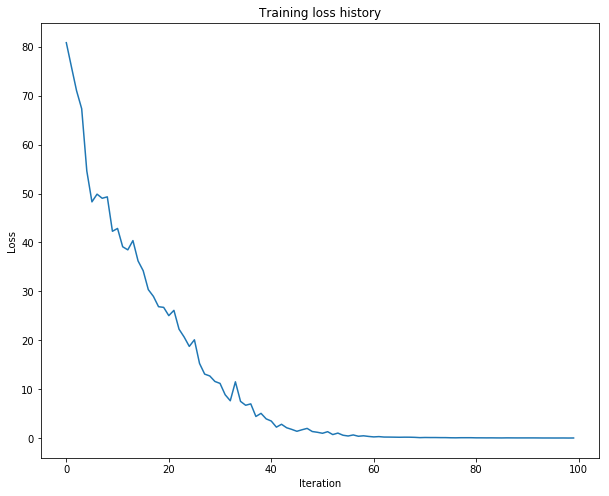

In [9]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='LSTM',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=512,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='Adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

### 4.2 LSTM test-time sampling

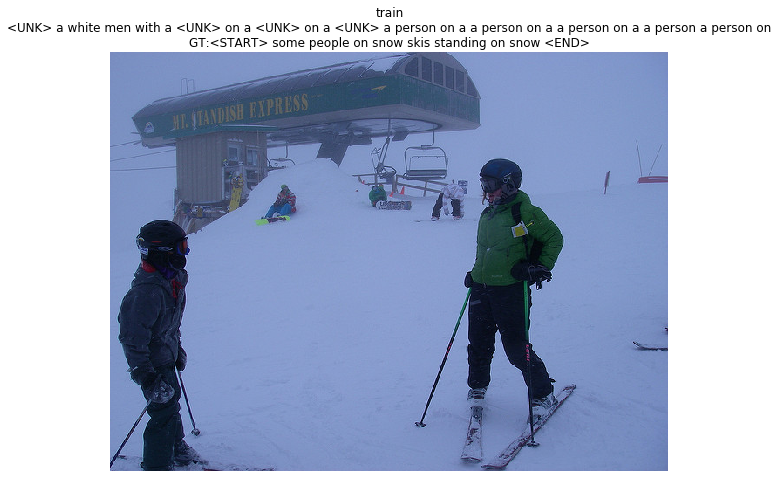

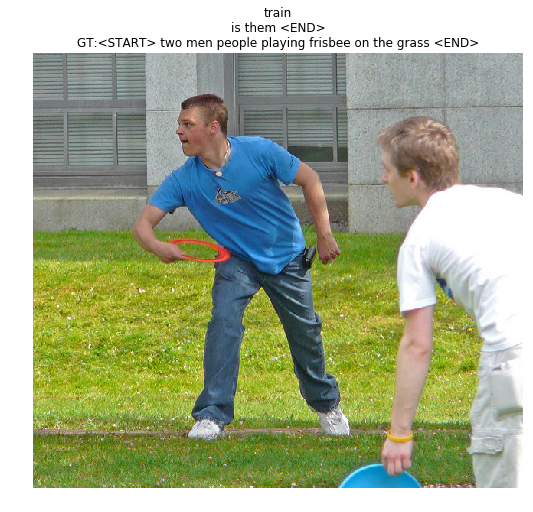

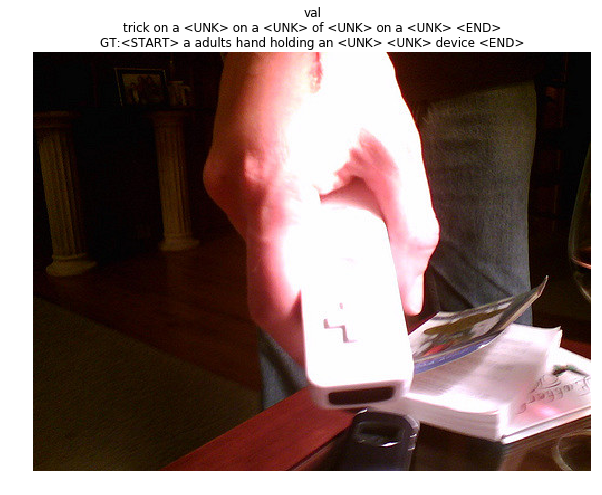

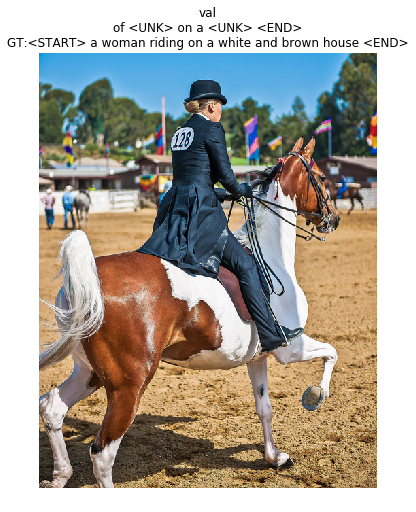

In [10]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

### 4.3 Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validatation set that are better than random.
Don't spend too much time on this part; we don't have any explicit accuracy thresholds you need to meet.

(Iteration 1 / 500) loss: 75.855226
(Iteration 51 / 500) loss: 38.665835
(Iteration 101 / 500) loss: 20.800816
(Iteration 151 / 500) loss: 11.789904
(Iteration 201 / 500) loss: 5.858321
(Iteration 251 / 500) loss: 1.660251
(Iteration 301 / 500) loss: 2.342077
(Iteration 351 / 500) loss: 0.420468
(Iteration 401 / 500) loss: 0.168355
(Iteration 451 / 500) loss: 0.101705


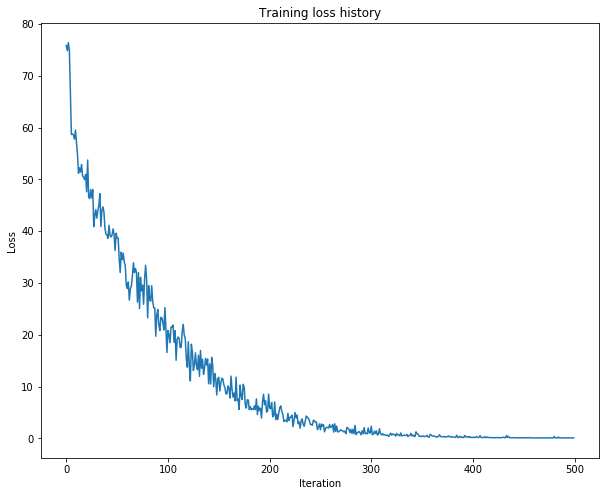

In [11]:
## To relieve overfitting, did:
## (1) incrase max_train from 50 to 500
## (2) decrease num_epoches from 50 to 25

small_data2 = load_coco_data(max_train=500)

good_model = CaptioningRNN(
      cell_type='LSTM',
      word_to_idx=data['word_to_idx'],
      input_dim=data['train_features'].shape[1],
      hidden_dim=512,
      wordvec_dim=512,
      dtype=np.float32,
    )

good_solver = CaptioningSolver(good_model, small_data2,
       update_rule='Adam',
       num_epochs=25,
       batch_size=25,
       optim_config={
         'learning_rate': 5e-3,
       },
       lr_decay=0.995,
       verbose=True, print_every=50,
     )

good_solver.train()

# Plot the training losses
plt.plot(good_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

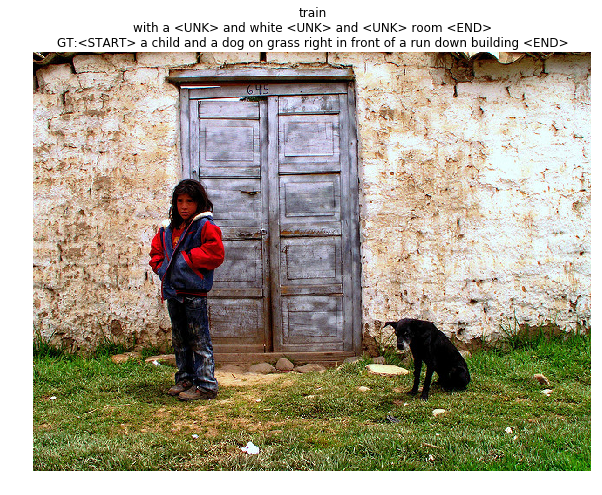

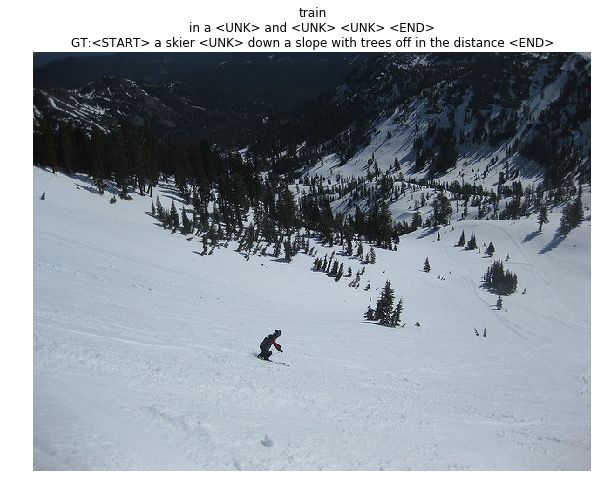

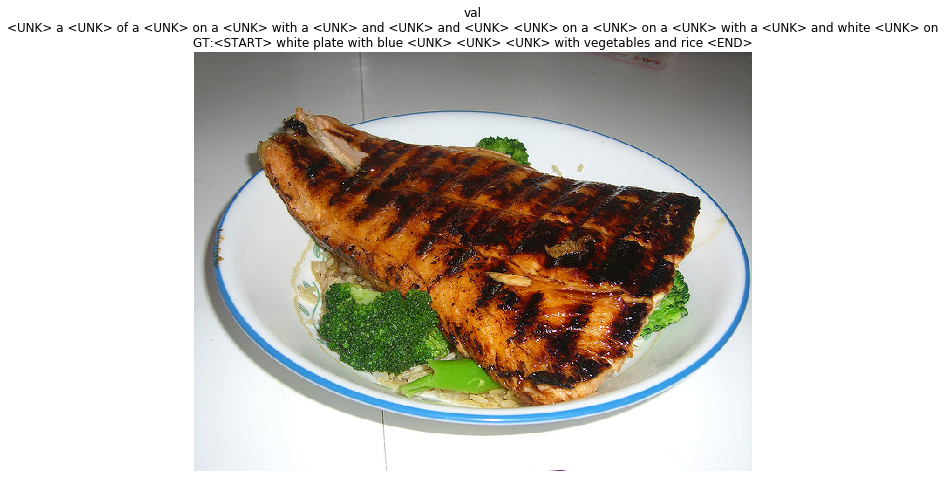

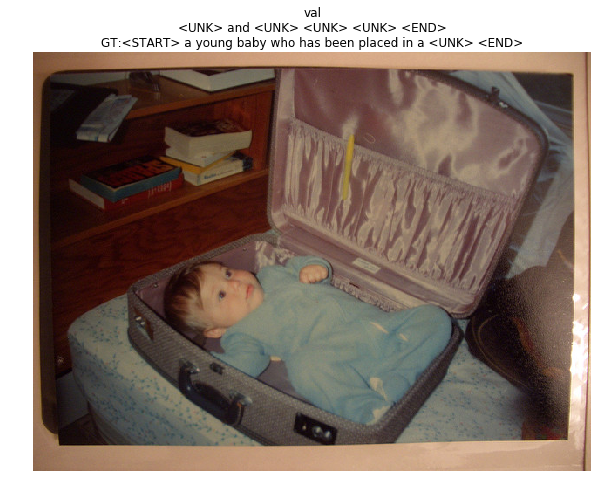

In [12]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data2, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = good_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()